# Making data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

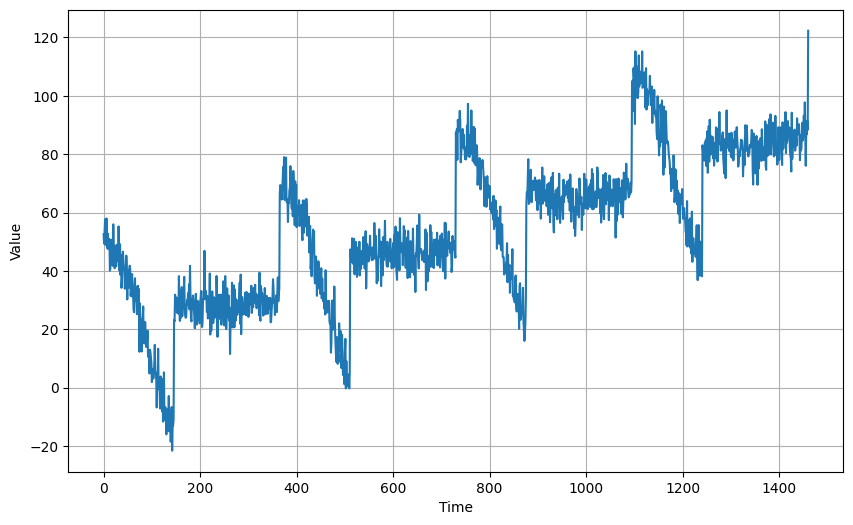

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [7]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [25]:
# Build the base model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model_baseline.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [27]:
model_baseline.fit(dataset, epochs=100, verbose=0)

In [28]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model_baseline.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 30ms/step
model prediction: [[46.084545]]


# Evaluating Base Model

In [29]:
print(model_baseline.predict(series[1:21][np.newaxis]))
print(series[21])

1/1 [==============================] - 0s 10ms/step
[[47.16507]]
47.335835


In [36]:
# Initialize a list
forecast = []
#More efficiently, generate forecast only on validation set
forecast_series = series[split_time-window_size:]
# Use the model to predict data points per window size
for time in range(window_size, len(forecast_series)):
  forecast.append(model_baseline.predict(forecast_series[time-window_size:time][np.newaxis], verbose=0))

In [37]:
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

length of the forecast list: 461
shape of the validation set: (461,)


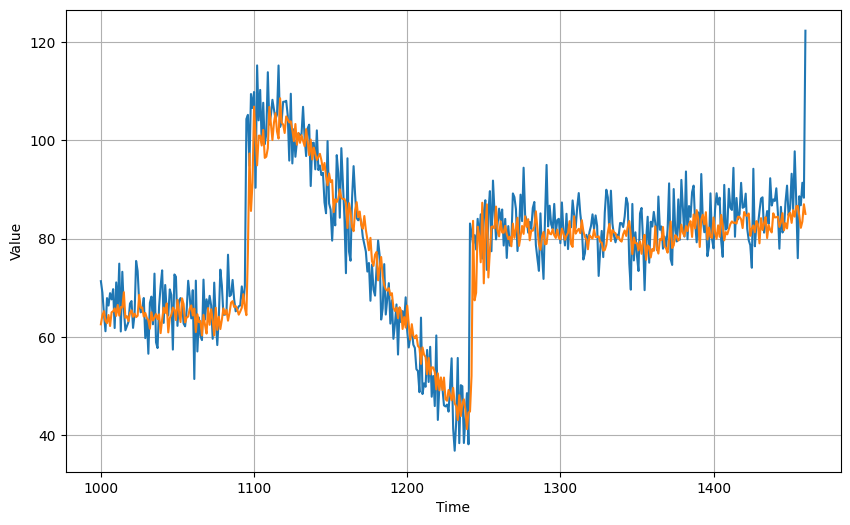

In [38]:
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [39]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

50.182903
5.110412


# Tuning the Learning Rate

In [72]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [73]:
# Set the learning rate scheduler - from 1e-8 to 1e-3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [74]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(momentum=0.9))

In [75]:
#Callbacks are functions called after every epoch
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 226.3879 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 456us/step - loss: 199.0146 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 436us/step - loss: 188.8980 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 394us/step - loss: 186.0331 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 389us/step - loss: 184.2223 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 419us/step - loss: 182.2329 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 443us/step - loss: 180.2593 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 424us/step - loss: 178.2448 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 402us/step - loss: 176.1088 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 386us/step - loss: 173.7887 - lr: 2.

(1e-08, 0.001, 0.0, 500.0)

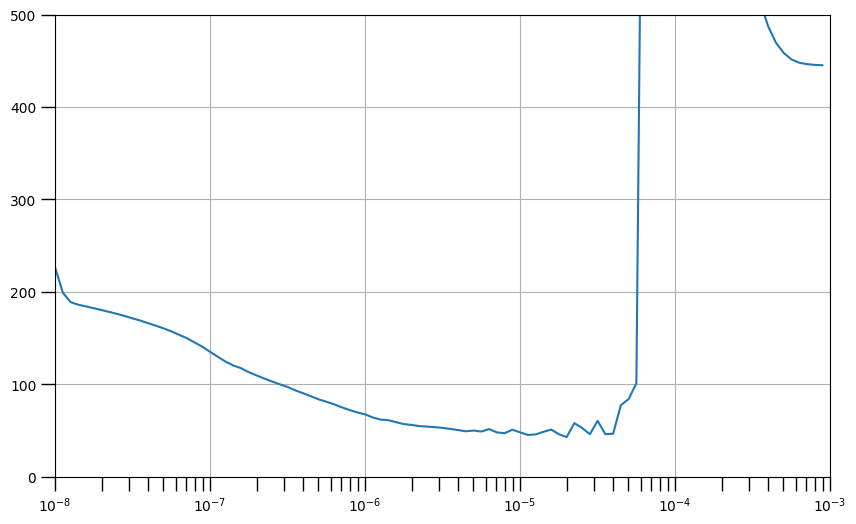

In [76]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 500])

In [78]:
op_epoch = np.argmin(history.history['loss'])
print(op_epoch)
print(np.min(history.history['loss']))

66
42.823211669921875


In [81]:
Optimal_lr = 1e-8 * 10**(op_epoch/20)
print(Optimal_lr)

1.995262314968879e-05


Retraining model using `Optimal_lr`

In [88]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [89]:
model_tune.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=Optimal_lr))
history = model_tune.fit(dataset, epochs=125)

Epoch 1/125
31/31 [==============================] - 0s 3ms/step - loss: 563.1071
Epoch 2/125
31/31 [==============================] - 0s 405us/step - loss: 108.6316
Epoch 3/125
31/31 [==============================] - 0s 572us/step - loss: 65.6280
Epoch 4/125
31/31 [==============================] - 0s 385us/step - loss: 71.0741
Epoch 5/125
31/31 [==============================] - 0s 452us/step - loss: 51.0238
Epoch 6/125
31/31 [==============================] - 0s 564us/step - loss: 49.3885
Epoch 7/125
31/31 [==============================] - 0s 445us/step - loss: 47.8569
Epoch 8/125
31/31 [==============================] - 0s 2ms/step - loss: 50.2900
Epoch 9/125
31/31 [==============================] - 1s 825us/step - loss: 48.2591
Epoch 10/125
31/31 [==============================] - 0s 426us/step - loss: 48.5619
Epoch 11/125
31/31 [==============================] - 0s 402us/step - loss: 54.8986
Epoch 12/125
31/31 [==============================] - 0s 389us/step - loss: 69.5699
Epo

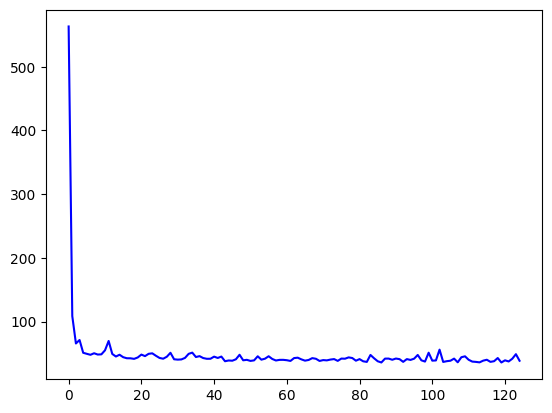

In [90]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

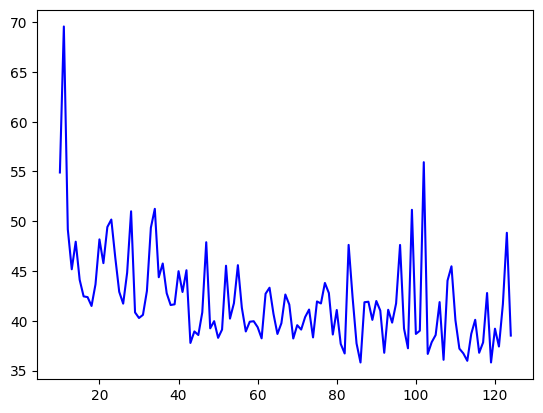

In [91]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

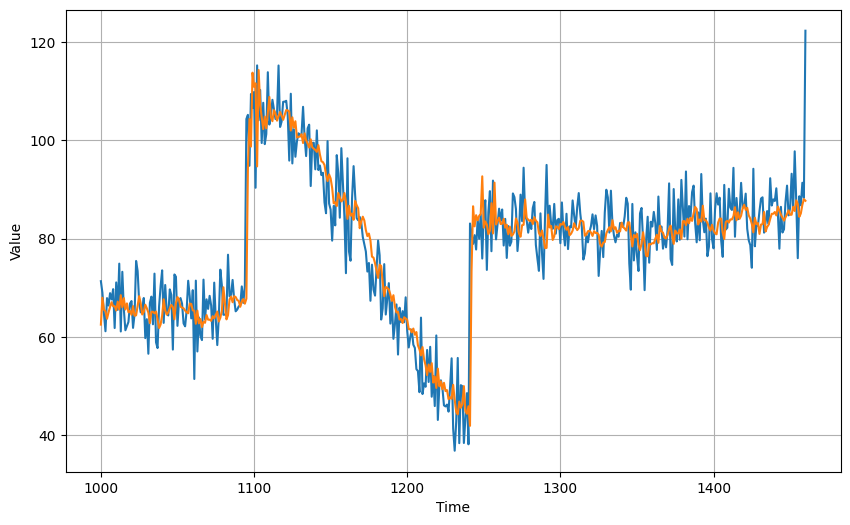

In [92]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [93]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

41.53779
4.7253814
